<a name="Inicio"></a>
# Data Analysis

#### Autor: *Ángel Pérez Lemonche*


## Descripción general

Este script utiliza las matrices de transición generadas en "Learning Paths with General *bricks*" con el fin de analizar el contenido de los datos para tomar futuras decisiones. Se puede realizar el mismo proceso utilizando **vectores de frecuencias**, normalizando por el número total de transiciones por semanas.

### Importación de librerías y declaración de funciones

In [1]:
# Librerías propias
import sys
sys.path.insert(0, './lib/')
import myfunclib as mf
import myplotlib as mp
import imp

mf = imp.reload(mf)
mp = imp.reload(mp)

# Librerías generales
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 30)
from IPython.core.display import display, HTML, clear_output

# Librerías ML
from sklearn.cluster import MeanShift
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor as MLP

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
# Gráficos
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import style
#style.use("ggplot")
plt.rcParams["figure.figsize"] = [10,10]

/home/angelpl/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Cargamos el fichero de entrada

In [2]:
infile_name = './files/brick_freq0h.json'
Usuarios, dfS, dfT = mf.loadFeatures(infile_name, Use_freq=False, min_trans=20)

2329 usuarios cargados.


In [3]:
df = pd.concat([Usuarios,dfT], axis = 1).set_index('users')

In [7]:
for x in df.columns:
    if 'S' in x:
        df.drop(x, inplace = True, axis = 1)
        
df = df.reindex_axis(sorted(df.columns), axis=1)

In [11]:
(df.sum(axis = 0)/sum(df.sum())*100).sort_values(ascending=False)

A2A    21.686851
E2E    19.479202
D2D    12.741851
V2E     9.594084
E2V     8.416543
V2V     7.922550
E2A     3.741803
A2E     2.639893
V2A     2.576229
A2V     2.351730
F2F     1.866833
D2V     1.124886
V2D     0.829544
D2E     0.536595
A2D     0.518405
E2D     0.432722
A2P     0.413097
P2V     0.392514
D2A     0.373845
A2F     0.334115
F2V     0.267579
V2F     0.263271
F2A     0.219712
V2P     0.155569
E2F     0.155091
F2P     0.155091
D2F     0.136422
F2E     0.123977
F2D     0.120147
E2P     0.084725
P2E     0.066536
D2P     0.062706
P2D     0.061749
P2F     0.053612
P2P     0.052654
P2A     0.047868
dtype: float64

Análisis de varianza y descripción de los datos

In [19]:
#mp.plotVariance(dfS)
#stats = dfT.describe()
#print stats

Reducción de dimensionalidad

In [4]:
# Selección de características
dfTn, dfSn = mf.featSelection(dfT, dfS, modo = 'normalized', info = .96, Use_Rest = True)

Modo: normalized
Número de características:  14


In [ ]:
# Transformación de características usando PCA
#dfTn, dfSn = mf.applyPCA(dfTn, dfSn, dimPCA = 10)

Análisis del conjunto de datos

In [ ]:
# Matrices de covarianza y correlación
#mp.plotMatrix(dfTn)

In [ ]:
# Matrices de dispersión e histogramas
#mp.plotScatter(dfTn)
#h = dfTn.hist() 

### MeanShift

In [ ]:
ms = MeanShift()

# Ajustamos las características
ms.fit(dfTn)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
n_clusters = len(np.unique(labels))
print "Número estimado de clusters:", n_clusters

In [ ]:
mp.plotVectors(cluster_centers, list(dfTn.columns))
mf.showTable(Usuarios, labels)

### Clustering jerárquico

In [ ]:
labels, centers = mf.clusterHierarchy(dfTn, depth = 50, link = 'centroid', threshold = .4, Plot = True)
#labels, centers = mf.clusterHierarchy(dfTn, depth = 50, link = 'centroid', threshold = 100, Plot = True)

In [ ]:
#mp.plotScatter(dfTn, which='scatterlabel', labels = labels, centers = centers, alpha=.15, colors = 'colormap')
mp.plotVectors(centers, list(dfTn.columns))

In [ ]:
mf.showTable(Usuarios, labels)

In [ ]:
#mp.plotScatter(dfTn, which='scatterlabel', labels = labels, centers = centers, alpha=.15)

### k-means

In [5]:
from sklearn.cluster import KMeans
n_clusters = 6
km = KMeans(n_clusters, random_state =206).fit(dfTn)

In [6]:
order = [1,2,3,4,5,0]
CC  = np.array([km.cluster_centers_[i]  for i in order])

In [7]:
CL = np.zeros(len(km.labels_))
for i in range(len(order)):
    for j in range(len(km.labels_)):
        if km.labels_[j]==order[i]:
            CL[j]=i

In [ ]:
CL

In [ ]:
mf = reload(mf)
mp = reload(mp)

#mp.plotScatter(dfTn, which='scatterlabel', labels = km.labels_, centers = km.cluster_centers_)
plt.rcParams["figure.figsize"] = [10,10]
mp.plotVectors(CC,list(dfTn.columns),colors = 'dark')


In [ ]:
mf.showTable(Usuarios, CL)

In [ ]:
#np.set_printoptions(threshold=np.nan)
#km.predict(dfSn[6])


In [8]:
#Intercluster distance
rs = range(100)
n_clusters = range(4,21)
avg = []

from sklearn.metrics import mean_squared_error as mse
for n in n_clusters:
    d = []
    for s in rs:
        km = KMeans(n, random_state = s).fit(dfTn)
        cc = km.cluster_centers_
        for j in range(len(cc)):
            for k in range(j+1,len(cc)):
                d.append(mse(cc[j],cc[k]))
    avg.append(np.mean(d))

In [9]:
from scipy.spatial import distance

def compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand    
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], 
                                                           [centers[0][i]], 'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term

    return(-BIC)

In [10]:
n_clusters = range(3,21)
rs = range(100)

BIC = []

for n in n_clusters:
    d = []
    for s in rs:
        km = KMeans(n, random_state = s).fit(dfTn)
        d.append(compute_bic(km,np.array(dfTn)))
    BIC.append(np.mean(d))
    

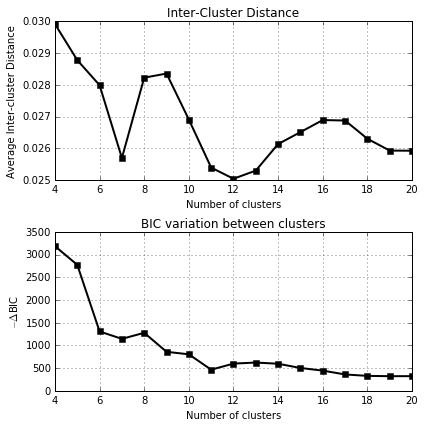

In [11]:
plt.figure(figsize=(6,6))
plt.subplot(211)
plt.plot(np.array(range(4,20+1)), avg, 'ks-',linewidth=2)
plt.ylabel('Average Inter-cluster Distance')
plt.xlabel('Number of clusters')
plt.title('Inter-Cluster Distance')
plt.grid(True)

plt.subplot(212)
difBIC = [-(BIC[i]-BIC[i-1]) for i in range(1,len(BIC))]
plt.plot(list(range(4,21)),difBIC,'ks-',linewidth=2)
plt.xlabel("Number of clusters")
plt.ylabel(r"$-\Delta$BIC")
plt.title('BIC variation between clusters')
plt.grid(True)

plt.tight_layout()

plt.savefig('distancias_clusters.eps', format='eps', dpi=1200)


In [ ]:
# K-means Por semanas
#list_centers = []
#list_labels = []
#for sem in range(0,6):
#    km = KMeans(n_clusters).fit(dfSn[sem])    
#    list_labels.append(km.labels_)
#    list_centers.append(km.cluster_centers_)


In [ ]:
#for sem in range(0,6):
#    mf.showTable(Usuarios, list_labels[sem])

In [ ]:
#colors = 12*['b','r','g','k','c','y','m']
#mp.plotScatter(dfSn, which='scatterlabel', labels = list_labels, centers = list_centers)
#mp.plotVectors(list_centers, dfSn[0].columns)

In [ ]:
#with open("transf.txt", "w") as outfile:

#    for i in list_labels:
#        for j in i:
#            outfile.write("%d"%(j)+" ")
#        outfile.write("\n")

### Modelo GMM

In [ ]:
meanBIC, meanAIC = mp.clusterValidationCurves(dfTn, num_comp = 20, nseeds = 100, covarType = 'full', verbose = False)

Media del mínimos BIC: 9.73 . Media de mínimos AIC: 17.31 .
Mínimo de media BIC: 8 . Mínimo de media AIC: 18 .

In [ ]:
plt.subplot(211)
plt.plot(np.array(range(4,20+1)), meanAIC[3:], 'ko-', label="AIC")
plt.plot(np.array(range(4,20+1)), meanBIC[3:], 'ks--', label="BIC")
plt.grid(True)
plt.xlabel("Number of components")
plt.ylabel("Log. probability")
plt.legend()
plt.subplot(212)
difbic = [-(meanBIC[i]-meanBIC[i-1]) for i in range(1,len(meanBIC))]
difaic = [-(meanAIC[i]-meanAIC[i-1]) for i in range(1,len(meanAIC))]

plt.plot(np.array(range(4,20+1)), difaic[2:], 'ko-', label=r"$\Delta$AIC")
plt.plot(np.array(range(4,20+1)), difbic[2:], 'ks--', label=r"$\Delta$BIC")
plt.grid(True)
plt.xlabel("Number of components")
plt.ylabel("Log. probability")
plt.legend()
plt.show()

In [ ]:
labels, centers = mf.clusterGMM(dfTn, num_comp = 8, 
                    covarType = 'full', seed = 20, verbose = 2)

In [ ]:
mp.plotVectors(centers, list(dfTn.columns), colors = 'colormap')
mf.showTable(Usuarios, labels)

In [ ]:
n_clusters = range(4,21)
covarType = 'full'
avg = []
for n in n_clusters:
    d = []
    for s in rs:
        labels, centers = mf.clusterGMM(dfTn, num_comp = n, 
                                    covarType = covarType, seed = s, verbose = 0, returnMetrics = False)
        cc = centers
        for j in range(len(cc)):
            for k in range(j+1,len(cc)):
                d.append(mse(cc[j],cc[k]))
    avg.append(np.mean(d))

In [ ]:
plt.plot(np.array(range(4,20+1)), avg, 'ks-')
plt.ylabel('Average Inter-cluster Distance')
plt.xlabel('Number of clusters')
plt.title('Inter-Cluster Distance')
plt.grid(True)